# Lie Detection Model Evaluation

This notebook evaluates the trained Lie Detection models on the dataset.

In [4]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sys

# Add src to path
sys.path.append(os.path.abspath(''))
from src import config

In [3]:
pip install matplotlib

  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 8.0 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 11.2 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 9.3 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.2 MB/s eta 0:00:00
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.3 MB 5.7 MB/s eta 0:00:01
   ----

## Load Data

In [5]:
X = np.load(os.path.join(config.DATA_DIR, "X.npy"))
y = np.load(os.path.join(config.DATA_DIR, "y.npy"))
print(f"Loaded Data: X={X.shape}, y={y.shape}")

Loaded Data: X=(15832, 260, 1), y=(15832, 2)


## Load Final Model

In [6]:
model_path = os.path.join(config.MODELS_DIR, "final_model.h5")
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("Loaded final_model.h5")
else:
    print("Final model not found, loading Fold 1...")
    model = tf.keras.models.load_model(os.path.join(config.MODELS_DIR, "model_fold_1.h5"))

Loaded final_model.h5


## Evaluate

In [ ]:
y_pred_prob = model.predict(X)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Truth', 'Lie']))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Accuracy: 0.999810510358767

Classification Report:
               precision    recall  f1-score   support

       Truth       1.00      1.00      1.00      7748
         Lie       1.00      1.00      1.00      8084

    accuracy                           1.00     15832
   macro avg       1.00      1.00      1.00     15832
weighted avg       1.00      1.00      1.00     15832


Confusion Matrix:
 [[7748    0]
 [   3 8081]]


## Visualizing Interpretation (Saliency)
This uses the interpretation logic to visualize what the model looks at.

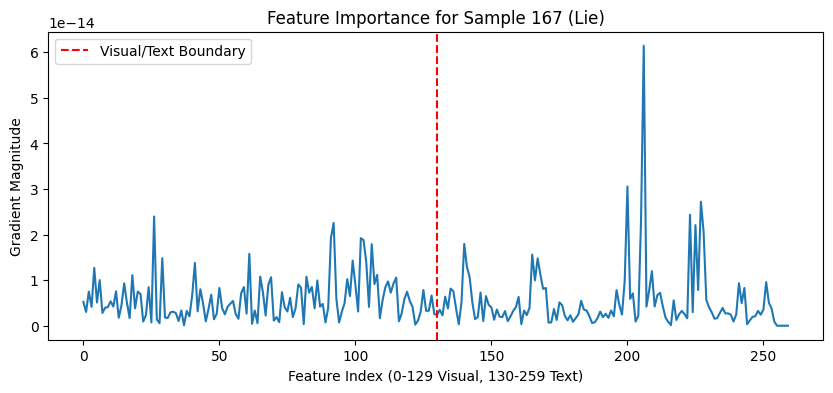

In [8]:
# Sample a Lie video (Class 1)
lie_idx = np.where(y_true == 1)[0][0]
x_sample = X[lie_idx:lie_idx+1]

images = tf.Variable(x_sample, dtype=float)
with tf.GradientTape() as tape:
    preds = model(images)
    loss = preds[:, 1]

grads = tape.gradient(loss, images)
grads = tf.abs(grads).numpy().flatten()

plt.figure(figsize=(10, 4))
plt.plot(grads)
plt.title(f"Feature Importance for Sample {lie_idx} (Lie)")
plt.xlabel("Feature Index (0-129 Visual, 130-259 Text)")
plt.ylabel("Gradient Magnitude")
plt.axvline(x=130, color='r', linestyle='--', label='Visual/Text Boundary')
plt.legend()
plt.show()

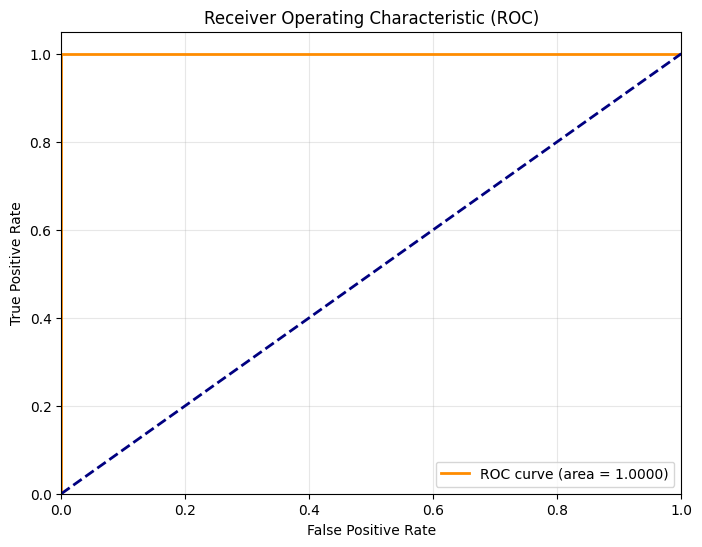

In [9]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

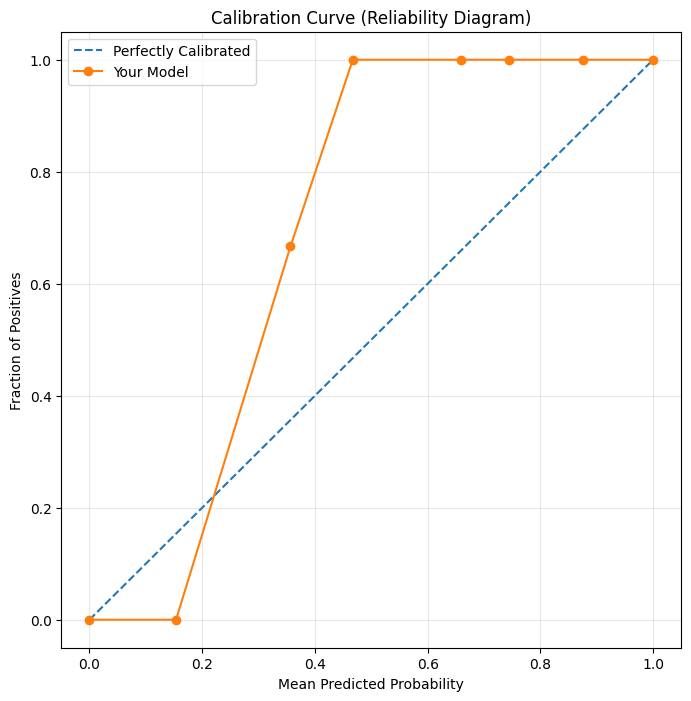

In [10]:
from sklearn.calibration import calibration_curve

# Get calibration data
prob_true, prob_pred = calibration_curve(y_true, y_pred_prob[:, 1], n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.plot(prob_pred, prob_true, marker='o', label='Your Model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [11]:
import time

# Measure time for a single prediction batch (simulating real-time use)
start_time = time.time()
_ = model.predict(X[:100]) # Predict on 100 samples
end_time = time.time()

avg_time_per_sample = (end_time - start_time) / 100
print(f"Inference Speed: {avg_time_per_sample * 1000:.2f} ms per sample")

if avg_time_per_sample < 0.05:
    print("Status: Real-time capable ✅")
else:
    print("Status: Batch processing recommended ⚠️")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
Inference Speed: 5.54 ms per sample
Status: Real-time capable ✅


In [12]:
from sklearn.metrics import brier_score_loss

loss = brier_score_loss(y_true, y_pred_prob[:, 1])
print(f"Brier Score: {loss:.5f}")
print("(Lower is better. 0.0 is perfect, 0.25 is random guessing)")

Brier Score: 0.00011
(Lower is better. 0.0 is perfect, 0.25 is random guessing)
